## Debugging the `LabelModel` with deps + higher-order cliques

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../") # go to parent dir

import numpy as np
import torch
import matplotlib.pyplot as plt
import mpmath

from synthetic.generate import (
    DataGenerator,
    ChainDependencies,
    TreeDependencies
)
from metal.label_model import LabelModel
from metal.label_model.utils import (
    compute_mu,
    compute_covariance,
    compute_inv_covariance,
    print_matrix,
    visualize_matrix
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Generating a dataset

In [2]:
np.random.seed(2)
N = 1000
M = 5
K = 2

In [3]:
# deps_graph = ChainDependencies(M)
deps_graph = TreeDependencies(M)
deps_graph.edges

[(0, 1), (0, 2), (0, 3), (1, 4)]

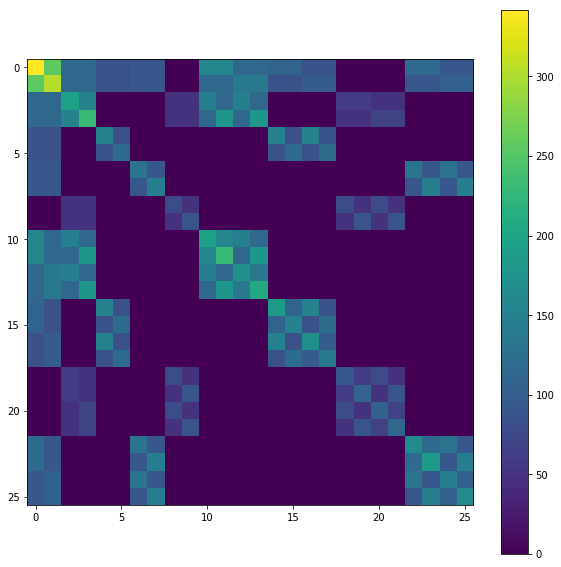

In [4]:
data = DataGenerator(N, M, k=K, deps_graph=deps_graph)
visualize_matrix(np.abs(data.sig_inv))

### Forming squashed version

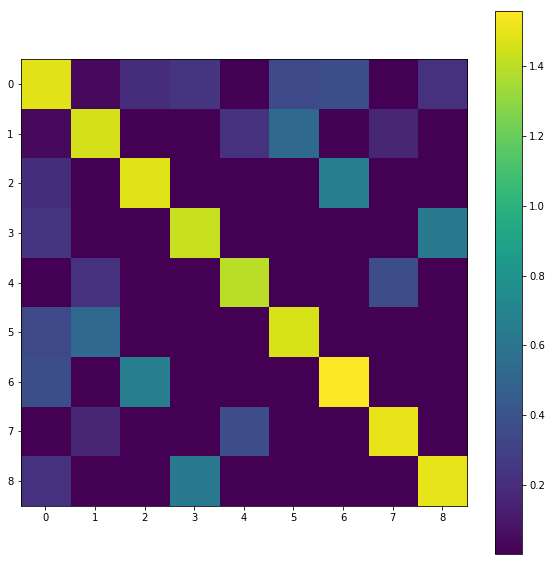

In [5]:
R = data.c_tree.R
R_mu = R @ data.mu
O_vis = R @ data.O @ R.T

S = R @ data.sig @ R.T
S_inv = np.linalg.inv(S)
visualize_matrix(np.abs(S_inv))

### Recovering $R\mu$

In [23]:
data.k = 1

lm = LabelModel(k=data.k, class_balance=data.p)

lm.train(
    data.L,
    deps=data.edges,
    all_unary_cliques=True,
    higher_order_cliques=True,
    n_epochs=10000,
    print_every=2000,
    lr=0.001,
    l2=0,
    O=O_vis,
    c_data=data.c_tree.c_data_1
)

R_mu_est = lm.mu.detach().numpy()
err = np.mean(np.abs(np.abs(R_mu_est) - np.abs(R_mu)))
print(f"Average absolute error: {err}")

1
Estimating Z...
[Epoch 0] Loss: 22.290062
[Epoch 2000] Loss: 0.032102
[Epoch 4000] Loss: 0.030101
[Epoch 6000] Loss: 0.028815
[Epoch 8000] Loss: 0.027902
[Epoch 9999] Loss: 0.027211
Estimating \mu...
[Epoch 0] Loss: 6.743495
[Epoch 2000] Loss: 0.000000
[Epoch 4000] Loss: 0.000000
[Epoch 6000] Loss: 0.000000
[Epoch 8000] Loss: 0.000000
[Epoch 9999] Loss: 0.000000
Average absolute error: 0.1523775636162189


### Recovering $\mu$ from $R\mu$

In [ ]:
# We assume we have access to the total rate of non-abstains, which is observable
R_sum = data.c_tree.R_sum
mu_lp = (data.mu.T @ R_sum.T).T
mu_lp

In [ ]:
np.hstack([data.c_tree.recover_mu(R_mu_est, mu_lp), data.mu])

In [ ]:
np.hstack([data.c_tree.recover_mu(R_mu, R2_mu, mu_lp), data.mu_true])

In [ ]:
from itertools import product
list(product(range(1, 3), repeat=2))

In [ ]:
M = np.array([
    [1, -1, -1, 1],
    [1, 1, 0, 0],
    [0, 0, 1, 1],
    [1, 0, 1, 0]
])
M

In [ ]:
np.linalg.inv(M)

## TODOs:
1. Code up `CliqueTree.R`
2. Code up routine to do both versions of `R` for non-unary cliques
3. Code up full parameter recovery
4. Code up check against true parameters
5. Test & clean up!

**Then, try for noisy data...?**